<a href="https://colab.research.google.com/github/chrismartel/COMP551/blob/main/projects/p1/adult_salary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mini-Project 1: Machine Learning 101

Christian Martel (260867191)

Luka Loignon (260871296)

Marie Guertin (260870552)

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd ~/.ssh/
!ssh-keygen -t rsa -b 4096
!ssh-keyscan -t rsa github.com >> ~/.ssh/known_hosts
!cat id_rsa.pub
# then, copy key to github account

[Errno 2] No such file or directory: '/root/.ssh/'
/content
Generating public/private rsa key pair.
Enter file in which to save the key (/root/.ssh/id_rsa): 
Created directory '/root/.ssh'.
Enter passphrase (empty for no passphrase): 
Enter same passphrase again: 
Your identification has been saved in /root/.ssh/id_rsa.
Your public key has been saved in /root/.ssh/id_rsa.pub.
The key fingerprint is:
SHA256:BFVWKXG16TM+G9jo/0UFYeTrmPDMaQvPvHo5aJPKfEs root@b6e127dff251
The key's randomart image is:
+---[RSA 4096]----+
|      ....+oo+*. |
|       . ....o + |
|        .  .  + .|
|       .     . ..|
|        S .   = .|
|           = X + |
|          Eo@.* .|
|       o .*B+. +.|
|        ++o=B+o..|
+----[SHA256]-----+
# github.com:22 SSH-2.0-babeld-a3fae306
cat: id_rsa.pub: No such file or directory


In [ ]:
!ssh-keyscan -t rsa github.com >> ~/.ssh/known_hosts


# github.com:22 SSH-2.0-babeld-a3fae306


In [ ]:
%cd /content/drive/MyDrive/git/COMP551/projects/p1

/content/drive/MyDrive/git/COMP551/projects/p1


# PART I: Adult Dataset

Prediction task is to determine whether someone makes over 50K a year.
https://archive.ics.uci.edu/ml/datasets/Adult

## Imports and Setup

In [75]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib inline

# other py files
import my_validation
import my_preprocessing

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
np.random.seed(1234)

## Data Preprocessing

### 1. Import Data

In [76]:
columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'salary']
train_df = pd.read_csv("data/adult.data", usecols = range(15), names = columns)
test_df = pd.read_csv("data/adult.test", usecols = range(15), names = columns)
display(train_df)
display(test_df)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,|1x3 Cross validator,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,25,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,<=50K.
2,38,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K.
3,28,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,>50K.
4,44,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,>50K.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16277,39,Private,215419.0,Bachelors,13.0,Divorced,Prof-specialty,Not-in-family,White,Female,0.0,0.0,36.0,United-States,<=50K.
16278,64,?,321403.0,HS-grad,9.0,Widowed,?,Other-relative,Black,Male,0.0,0.0,40.0,United-States,<=50K.
16279,38,Private,374983.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K.
16280,44,Private,83891.0,Bachelors,13.0,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455.0,0.0,40.0,United-States,<=50K.


### Check all unique values per feature

It is observed that age in the test dataset is in string format. It should be convert to int format.

It is observed that unknown values are represented by '?'. These values should be impute.

It is observed that labels in 'salary' column from test dataframe have a dot at the end

In [77]:
# print unique values for each column
print("TEST DATASET")
for c in test_df.columns:
    print("{c}: ".format(c=c), test_df[c].unique())
    
print("\nTRAIN DATASET")
for c in train_df.columns:
    print("{c}: ".format(c=c), train_df[c].unique())

TEST DATASET
age:  ['|1x3 Cross validator' '25' '38' '28' '44' '18' '34' '29' '63' '24' '55'
 '65' '36' '26' '58' '48' '43' '20' '37' '40' '72' '45' '22' '23' '54'
 '32' '46' '56' '17' '39' '52' '21' '42' '33' '30' '47' '41' '19' '69'
 '50' '31' '59' '49' '51' '27' '57' '61' '64' '79' '73' '53' '77' '80'
 '62' '35' '68' '66' '75' '60' '67' '71' '70' '90' '81' '74' '78' '82'
 '83' '85' '76' '84' '89' '88' '87']
workclass:  [nan ' Private' ' Local-gov' ' ?' ' Self-emp-not-inc' ' Federal-gov'
 ' State-gov' ' Self-emp-inc' ' Without-pay' ' Never-worked']
fnlwgt:  [    nan 226802.  89814. ... 349230. 321403.  83891.]
education:  [nan ' 11th' ' HS-grad' ' Assoc-acdm' ' Some-college' ' 10th'
 ' Prof-school' ' 7th-8th' ' Bachelors' ' Masters' ' Doctorate' ' 5th-6th'
 ' Assoc-voc' ' 9th' ' 12th' ' 1st-4th' ' Preschool']
education-num:  [nan  7.  9. 12. 10.  6. 15.  4. 13. 14. 16.  3. 11.  5.  8.  2.  1.]
marital-status:  [nan ' Never-married' ' Married-civ-spouse' ' Widowed' ' Divorced'
 ' Sepa

### 2. Clean up Data

1. Categorical data is not stripped, labels contain left white spaces.

2. First row of test data set is junk data

3. Age column in test data set are strings, should be convert to int.

4. Remove dot from test dataset salary labels



In [78]:
# 1.
train_df = my_preprocessing.strip_labels(train_df)
test_df = my_preprocessing.strip_labels(test_df)

# 2.
test_df.drop(labels=0, inplace = True)

# 3.
test_df['age'] = test_df['age'].astype('int64', errors='ignore')

#4.

test_df['salary'] = test_df['salary'].apply(lambda label: label[:-1])



### 3. Remove Useless Columns

From the imported datasets, we observe that the capital-gain and capital-loss columns contain mostly zeros. These columns are not important features so they will be removed.

In [79]:
# remove columns with too much missing data
train_df.drop(columns = ['capital-gain', 'capital-loss'], inplace = True)
test_df.drop(columns = ['capital-gain', 'capital-loss'], inplace = True)

### 4. Data Imputation

For continuous data: replace Nan values or invalid values with mean value of column

For categorical data: replace Nan values or invalid values with most occurring features

In [80]:
# map the invalid entries for each column
invalid_entries_dict = {
    'age':[],
    'workclass':['?'],
    'fnlwgt':[],
    'education':[],
    'education-num':[],
    'marital-status':[],
    'occupation':['?'],
    'relationship':[],
    'race':[],
    'sex':[],
    'hours-per-week':[],
    'native-country':['?']
}
train_df = my_preprocessing.imputation(train_df, invalid_entries_dict)
test_df = my_preprocessing.imputation(test_df, invalid_entries_dict)

### 5. Categorical Features One-Hot-Encoding 

In [81]:
# pop prediction column
y_train, y_test = train_df.pop('salary'), test_df.pop('salary')

# one-hot-encode categorical features
train_df = my_preprocessing.ohe(train_df)
test_df = my_preprocessing.ohe(test_df)
        
# add back prediction column
train_df, test_df = pd.concat([train_df, y_train],axis=1), pd.concat([test_df, y_test],axis=1)
display(train_df)
display(test_df)

,age,fnlwgt,education-num,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,education_10th,education_11th,education_12th,education_1st-4th,education_5th-6th,education_7th-8th,education_9th,education_Assoc-acdm,education_Assoc-voc,education_Bachelors,education_Doctorate,education_HS-grad,education_Masters,education_Preschool,education_Prof-school,education_Some-college,marital-status_Divorced,marital-status_Married-AF-spouse,marital-status_Married-civ-spouse,marital-status_Married-spouse-absent,marital-status_Never-married,marital-status_Separated,marital-status_Widowed,occupation_Adm-clerical,occupation_Armed-Forces,occupation_Craft-repair,occupation_Exec-managerial,occupation_Farming-fishing,occupation_Handlers-cleaners,occupation_Machine-op-inspct,occupation_Other-service,occupation_Priv-house-serv,occupation_Prof-specialty,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,relationship_Husband,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Female,sex_Male,native-country_Cambodia,native-country_Canada,native-country_China,native-country_Columbia,native-country_Cuba,native-country_Dominican-Republic,native-country_Ecuador,native-country_El-Salvador,native-country_England,native-country_France,native-country_Germany,native-country_Greece,native-country_Guatemala,native-country_Haiti,native-country_Holand-Netherlands,native-country_Honduras,native-country_Hong,native-country_Hungary,native-country_India,native-country_Iran,native-country_Ireland,native-country_Italy,native-country_Jamaica,native-country_Japan,native-country_Laos,native-country_Mexico,native-country_Nicaragua,native-country_Outlying-US(Guam-USVI-etc),native-country_Peru,native-country_Philippines,native-country_Poland,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia,salary
0,39,77516,13,40,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,<=50K
1,50,83311,13,13,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,<=50K
2,38,215646,9,40,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,<=50K
3,53,234721,7,40,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,<=50K
4,28,338409,13,40,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,257302,12,38,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,

,age,fnlwgt,education-num,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,education_10th,education_11th,education_12th,education_1st-4th,education_5th-6th,education_7th-8th,education_9th,education_Assoc-acdm,education_Assoc-voc,education_Bachelors,education_Doctorate,education_HS-grad,education_Masters,education_Preschool,education_Prof-school,education_Some-college,marital-status_Divorced,marital-status_Married-AF-spouse,marital-status_Married-civ-spouse,marital-status_Married-spouse-absent,marital-status_Never-married,marital-status_Separated,marital-status_Widowed,occupation_Adm-clerical,occupation_Armed-Forces,occupation_Craft-repair,occupation_Exec-managerial,occupation_Farming-fishing,occupation_Handlers-cleaners,occupation_Machine-op-inspct,occupation_Other-service,occupation_Priv-house-serv,occupation_Prof-specialty,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,relationship_Husband,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Female,sex_Male,native-country_Cambodia,native-country_Canada,native-country_China,native-country_Columbia,native-country_Cuba,native-country_Dominican-Republic,native-country_Ecuador,native-country_El-Salvador,native-country_England,native-country_France,native-country_Germany,native-country_Greece,native-country_Guatemala,native-country_Haiti,native-country_Honduras,native-country_Hong,native-country_Hungary,native-country_India,native-country_Iran,native-country_Ireland,native-country_Italy,native-country_Jamaica,native-country_Japan,native-country_Laos,native-country_Mexico,native-country_Nicaragua,native-country_Outlying-US(Guam-USVI-etc),native-country_Peru,native-country_Philippines,native-country_Poland,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia,salary
1,25,226802.0,7.0,40.0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,<=50K
2,38,89814.0,9.0,50.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,<=50K
3,28,336951.0,12.0,40.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,>50K
4,44,160323.0,10.0,40.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,>50K
5,18,103497.0,10.0,30.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16277,39,215419.0,13.0,36.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

### 6. Split Train Test Sets

In [82]:
x_train_df, y_train_df = train_df.iloc[:,:-1], train_df.iloc[:,-1]
x_test_df, y_test_df = test_df.iloc[:,:-1], test_df.iloc[:,-1]

### 7. Normalize Column Data

Normalization is important for KNN since distance is a major factor in predictions.

In [83]:
for c in x_train_df.columns:
  x_train_df[c] = (x_train_df[c] - x_train_df[c].min()) / (x_train_df[c].max() - x_train_df[c].min())    
for c in x_test_df.columns:
  x_test_df[c] = (x_test_df[c] - x_test_df[c].min()) / (x_test_df[c].max() - x_test_df[c].min())    
x_train_df

,age,fnlwgt,education-num,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,education_10th,education_11th,education_12th,education_1st-4th,education_5th-6th,education_7th-8th,education_9th,education_Assoc-acdm,education_Assoc-voc,education_Bachelors,education_Doctorate,education_HS-grad,education_Masters,education_Preschool,education_Prof-school,education_Some-college,marital-status_Divorced,marital-status_Married-AF-spouse,marital-status_Married-civ-spouse,marital-status_Married-spouse-absent,marital-status_Never-married,marital-status_Separated,marital-status_Widowed,occupation_Adm-clerical,occupation_Armed-Forces,occupation_Craft-repair,occupation_Exec-managerial,occupation_Farming-fishing,occupation_Handlers-cleaners,occupation_Machine-op-inspct,occupation_Other-service,occupation_Priv-house-serv,occupation_Prof-specialty,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,relationship_Husband,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Female,sex_Male,native-country_Cambodia,native-country_Canada,native-country_China,native-country_Columbia,native-country_Cuba,native-country_Dominican-Republic,native-country_Ecuador,native-country_El-Salvador,native-country_England,native-country_France,native-country_Germany,native-country_Greece,native-country_Guatemala,native-country_Haiti,native-country_Holand-Netherlands,native-country_Honduras,native-country_Hong,native-country_Hungary,native-country_India,native-country_Iran,native-country_Ireland,native-country_Italy,native-country_Jamaica,native-country_Japan,native-country_Laos,native-country_Mexico,native-country_Nicaragua,native-country_Outlying-US(Guam-USVI-etc),native-country_Peru,native-country_Philippines,native-country_Poland,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,0.301370,0.044302,0.800000,0.397959,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.452055,0.048238,0.800000,0.122449,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.287671,0.138113,0.533333,0.397959,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.493151,0.151068,0.400000,0.397959,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

### 8. Chi-Squared Feature Selection

Method that allows to select the K most important features of a dataset, features to which the prediction variable is the most dependent.

We will select the 30 most important features out of 171 possibilities.

In [86]:
from sklearn.feature_selection import SelectKBest, chi2
fs = SelectKBest(score_func=chi2, k='all')
fs.fit(x_train, y_train)
x_train = fs.transform(x_train)

fs.fit(x_test, y_test)
x_test = fs.transform(x_test)
display(x_test)

array([[25, 7.0, 40.0, ..., 1, 0, 1],
       [38, 9.0, 50.0, ..., 0, 0, 1],
       [28, 12.0, 40.0, ..., 0, 0, 1],
       ...,
       [38, 13.0, 50.0, ..., 0, 0, 1],
       [44, 13.0, 40.0, ..., 0, 0, 1],
       [35, 13.0, 60.0, ..., 0, 0, 1]], dtype=object)

### 9. Convert to Numpy

In [87]:
# random permutations of indices
inds = np.random.permutation(range(x_train.shape[0]))

# split into features set and prediction set
x_train, y_train = x_train[inds,:], y_train_df.to_numpy()[inds]
y_test = y_train_df.to_numpy()

## Experiments

### 1. KNN

In [88]:
from sklearn.neighbors import KNeighborsClassifier

# number of folds for L-fold cross-validation
L = 5

# range of number of nearest neighbors (K)
K_list = range(1,31) # [1,2,...,30]

### Experiment with Scaling Features

In [89]:
scale_factor = [2,3,4,5,6,7,8]
best_err_rate = 1.0

for i in scale_factor:
  x_train[:,[4,22,23,25,39]] = i * x_train[:,[4,22,23,25,39]]
  
  sizes = [1000]

  for s in sizes:
      # select s random samples from train dataset
      x_subset, y_subset = x_train[inds[:s]], y_train[inds[:s]]
      
      # apply cross validation to get validation and train accuracy matrices 
      err_val_matrix, err_train_matrix = my_validation.knn_cross_validation(x_subset, y_subset, K_list, L, my_validation.error_rate)
      
      err_val_means = np.mean(err_val_matrix, axis=1)
      
      plt.title('Error Rate of KNN for Varying K Values with {size} Samples'.format(size = s))
      plt.plot(K_list, np.mean(err_train_matrix, axis=1),  label='train')
      plt.errorbar(K_list, err_val_means, np.std(err_val_matrix, axis=1), label='validation')
      plt.legend()
      plt.xlabel('K (number of neighbours)')
      plt.ylabel('error rate')
      plt.ylim(0,0.5)
      plt.show()

      best_k = K_list[np.argmin(err_val_means)]
      print("Best K parameter: {k}".format(k=best_k))

      model = KNeighborsClassifier(n_neighbors=best_k)
      model.fit(x_train, y_train)
      y_pred = model.predict(x_test)

      err_rate = my_validation.error_rate(y_test, y_pred)
      if err_rate < best_err_rate:
        best_err_rate = err_rate

print("Error Rate on Test Set: {err_rate}".format(err_rate=best_err_rate))

IndexError: ignored

#### Cross-Validation

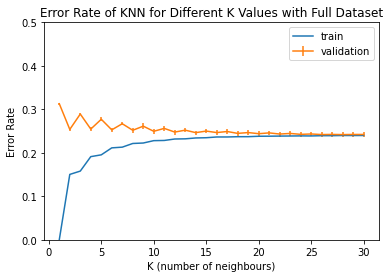

Best K parameter: 28


In [ ]:
# knn cross-validation on full dataset
err_val_matrix, err_train_matrix = my_validation.knn_cross_validation(x_train, y_train, K_list, L, my_validation.error_rate)
err_val_means = np.mean(err_val_matrix, axis=1)

# Visualize
plt.title('Error Rate of KNN for Different K Values with Full Dataset')
plt.plot(K_list, np.mean(err_train_matrix, axis=1),  label='train')
plt.errorbar(K_list, err_val_means, np.std(err_val_matrix, axis=1), label='validation')
plt.legend()
plt.xlabel('K (number of neighbours)')
plt.ylabel('Error Rate')
plt.ylim(0,0.5)
plt.show()

# The best K parameter is the one providing the smallest error rate
best_k = K_list[np.argmin(err_val_means)]
print("Best K parameter: {k}".format(k=best_k))

#### Sample Growing Data

Observe the effect of growing the sample size on the training and validation errors.

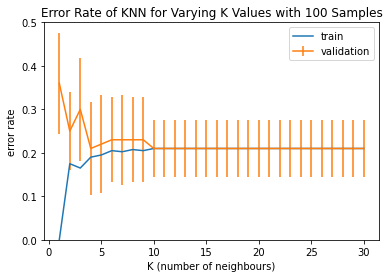

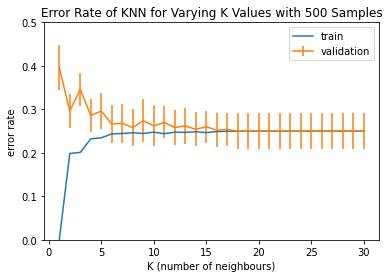

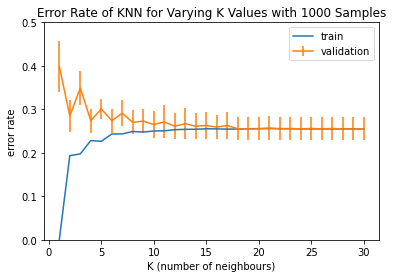

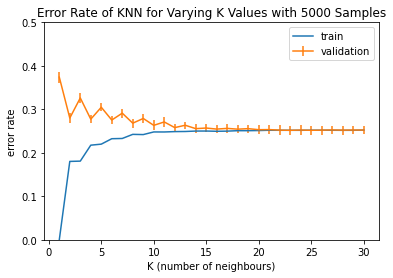

In [ ]:
sizes = [100, 500, 1000, 5000]

for s in sizes:
    # select s random samples from train dataset
    x_subset, y_subset = x_train[inds[:s]], y_train[inds[:s]]
    
    # apply cross validation to get validation and train accuracy matrices 
    err_val_matrix, err_train_matrix = my_validation.knn_cross_validation(x_subset, y_subset, K_list, L, my_validation.error_rate)
    
    err_val_means = np.mean(err_val_matrix, axis=1)
    
    plt.title('Error Rate of KNN for Varying K Values with {size} Samples'.format(size = s))
    plt.plot(K_list, np.mean(err_train_matrix, axis=1),  label='train')
    plt.errorbar(K_list, err_val_means, np.std(err_val_matrix, axis=1), label='validation')
    plt.legend()
    plt.xlabel('K (number of neighbours)')
    plt.ylabel('error rate')
    plt.ylim(0,0.5)
    plt.show()

#### Use Best K Parameter on Test Set

In [ ]:
model = KNeighborsClassifier(n_neighbors=best_k)
start_time = time.time()
model.fit(x_train, y_train)
tr_end = time.time()
tr_time = tr_end - start_time

y_pred = model.predict(x_test)
pr_end = time.time()
pred_time = pr_end - tr_end

err_rate = my_validation.error_rate(y_test, y_pred)

print("Error Rate on Test Set: {err_rate}".format(err_rate=err_rate))
print("Training time: {tr_time}".format(tr_time=tr_time))
print("Prediction time: {pred_time}".format(pred_time=pred_time))

Error Rate on Test Set: 0.23622627602727106
Training time: 0.3506479263305664
Prediction time: 0.7169492244720459


### 2. DECISION-TREE

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Maximum tree depth hyper-parameter
max_depth_list = list(range(1,31)) #1-30

# Minimum samples per leaf parameter
min_samples_per_leaf_list = list(range(1, 301, 5)) #1-300


### For Maximum Depth Parameter

#### Cross-Validation

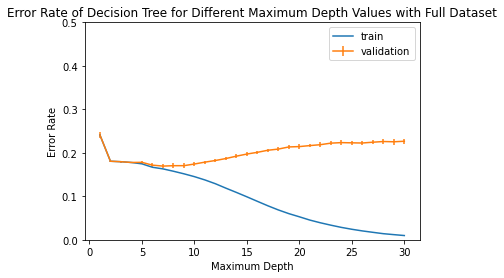

Best max depth parameter: 7


In [ ]:
# decision tree cross-validation on full dataset
err_val_matrix, err_train_matrix = my_validation.dt_cross_validation(x_train, y_train, max_depth_list=max_depth_list, L=L, validation_metric_fn=my_validation.error_rate)
err_val_means = np.mean(err_val_matrix, axis=1)

# Visualize
plt.title('Error Rate of Decision Tree for Different Maximum Depth Values with Full Dataset')
plt.plot(max_depth_list, np.mean(err_train_matrix, axis=1),  label='train')
plt.errorbar(max_depth_list, err_val_means, np.std(err_val_matrix, axis=1), label='validation')
plt.legend()
plt.xlabel('Maximum Depth')
plt.ylabel('Error Rate')
plt.ylim(0,0.5)
plt.show()

# The best K parameter is the one providing the smallest error rate
best_max_depth = max_depth_list[np.argmin(err_val_means)]
print("Best max depth parameter: {k}".format(k=best_max_depth))

#### Sample Growing Data

Observe the effect of growing the sample size on the training and validation errors.

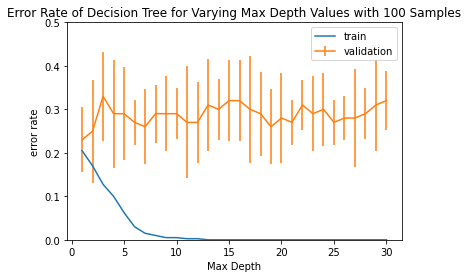

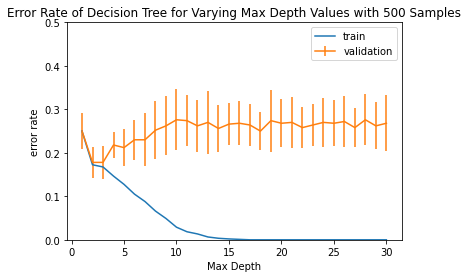

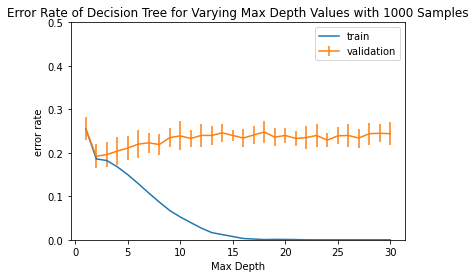

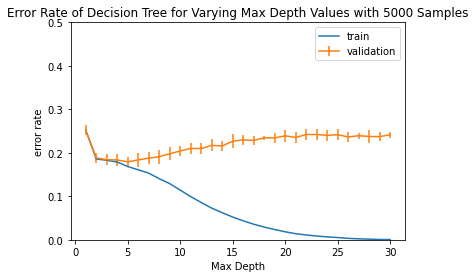

In [ ]:
sizes = [100, 500, 1000, 5000]

for s in sizes:
    # select s random samples from train dataset
    x_subset, y_subset = x_train[inds[:s]], y_train[inds[:s]]
    
    # apply cross validation to get validation and train accuracy matrices 
    err_val_matrix, err_train_matrix = my_validation.dt_cross_validation(x_subset, y_subset, max_depth_list=max_depth_list, L=L, validation_metric_fn=my_validation.error_rate)
    
    err_val_means = np.mean(err_val_matrix, axis=1)
    
    plt.title('Error Rate of Decision Tree for Varying Max Depth Values with {size} Samples'.format(size = s))
    plt.plot(max_depth_list, np.mean(err_train_matrix, axis=1),  label='train')
    plt.errorbar(max_depth_list, err_val_means, np.std(err_val_matrix, axis=1), label='validation')
    plt.legend()
    plt.xlabel('Max Depth')
    plt.ylabel('error rate')
    plt.ylim(0,0.5)
    plt.show()

#### Use Best Max Depth Parameter on Test Set

In [ ]:
model = DecisionTreeClassifier(max_depth=best_max_depth)
start_time = time.time()
model.fit(x_train, y_train)
tr_end = time.time()
tr_time = tr_end - start_time

y_pred = model.predict(x_test)
pr_end = time.time()
pred_time = pr_end - tr_end

print("Error Rate on Test Set: {err_rate}".format(err_rate=err_rate))
print("Training time: {tr_time}".format(tr_time=tr_time))
print("Prediction time: {pred_time}".format(pred_time=pred_time))

Error Rate on Test Set: 0.23622627602727106
Training time: 0.19798588752746582
Prediction time: 0.015593767166137695


### For Minimum Samples per Leaf Parameter

#### Cross-Validation

Vary the minimum samples per leaf, with a constant None max depth.

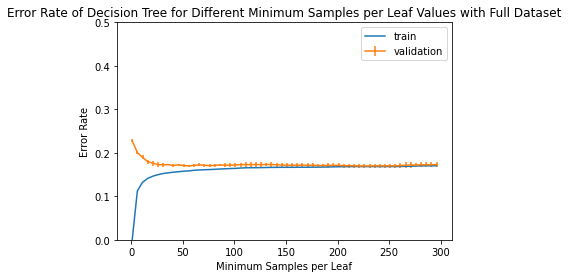

Best min samples per leaf parameter: 221


In [ ]:
# decision tree cross-validation on full dataset
err_val_matrix, err_train_matrix = my_validation.dt_cross_validation(x_train, y_train, min_samples_per_leaf_list=min_samples_per_leaf_list, L=L, validation_metric_fn=my_validation.error_rate)
err_val_means = np.mean(err_val_matrix, axis=1)

# Visualize
plt.title('Error Rate of Decision Tree for Different Minimum Samples per Leaf Values with Full Dataset')
plt.plot(min_samples_per_leaf_list, np.mean(err_train_matrix, axis=1),  label='train')
plt.errorbar(min_samples_per_leaf_list, err_val_means, np.std(err_val_matrix, axis=1), label='validation')
plt.legend()
plt.xlabel('Minimum Samples per Leaf')
plt.ylabel('Error Rate')
plt.ylim(0,0.5)
plt.show()

best_min_samples = min_samples_per_leaf_list[np.argmin(err_val_means)]
print("Best min samples per leaf parameter: {k}".format(k=best_min_samples))

#### Sample Growing Data

Observe the effect of growing the sample size on the training and validation errors.

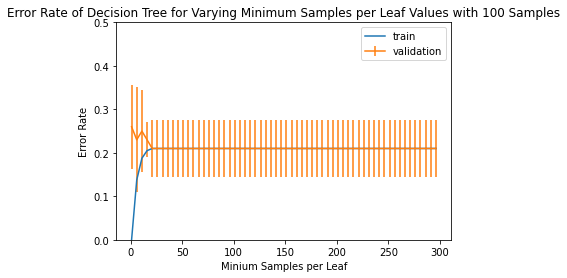

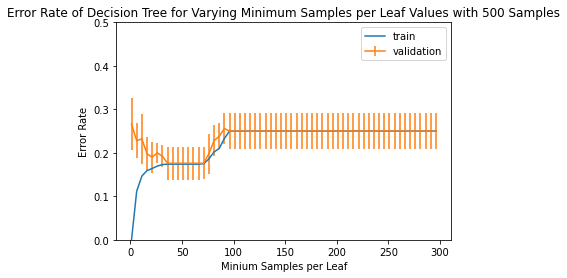

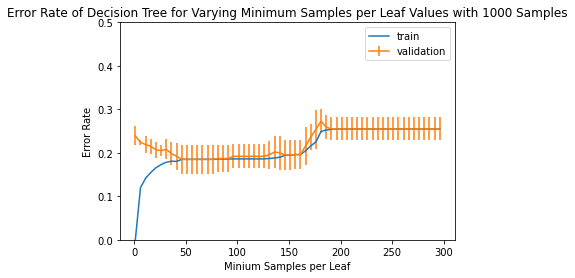

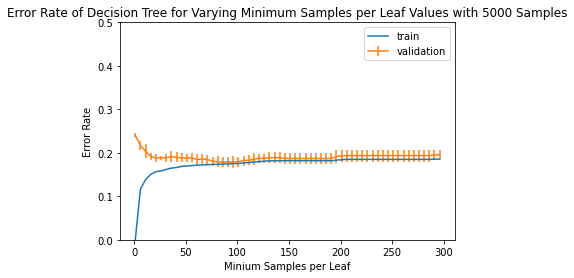

In [ ]:
sizes = [100, 500, 1000, 5000]

for s in sizes:
    # select s random samples from train dataset
    x_subset, y_subset = x_train[inds[:s]], y_train[inds[:s]]
    
    # apply cross validation to get validation and train accuracy matrices 
    err_val_matrix, err_train_matrix = my_validation.dt_cross_validation(x_subset, y_subset, min_samples_per_leaf_list=min_samples_per_leaf_list, L=L, validation_metric_fn=my_validation.error_rate)
    
    err_val_means = np.mean(err_val_matrix, axis=1)
    
    plt.title('Error Rate of Decision Tree for Varying Minimum Samples per Leaf Values with {size} Samples'.format(size = s))
    plt.plot(min_samples_per_leaf_list, np.mean(err_train_matrix, axis=1),  label='train')
    plt.errorbar(min_samples_per_leaf_list, err_val_means, np.std(err_val_matrix, axis=1), label='validation')
    plt.legend()
    plt.xlabel('Minium Samples per Leaf')
    plt.ylabel('Error Rate')
    plt.ylim(0,0.5)
    plt.show()

#### Use Best Min Sampled per Leaf Parameter on Test Set

In [ ]:
model = DecisionTreeClassifier(min_samples_leaf=best_min_samples)
start_time = time.time()
model.fit(x_train, y_train)
tr_end = time.time()
tr_time = tr_end - start_time

y_pred = model.predict(x_test)
pr_end = time.time()
pred_time = pr_end - tr_end

err_rate = my_validation.error_rate(y_test, y_pred)

print("Error Rate on Test Set: {err_rate}".format(err_rate=err_rate))
print("Training time: {tr_time}".format(tr_time=tr_time))
print("Prediction time: {pred_time}".format(pred_time=pred_time))

Error Rate on Test Set: 0.23622627602727106
Training time: 0.21139287948608398
Prediction time: 0.014400243759155273


### Grid Search
#### Max Depth and Min Samples per Leaf Combined

#### Cross-Validation

(array([8]), array([3]))

Best max depth parameter: 9
Best min samples per leaf parameter: 31


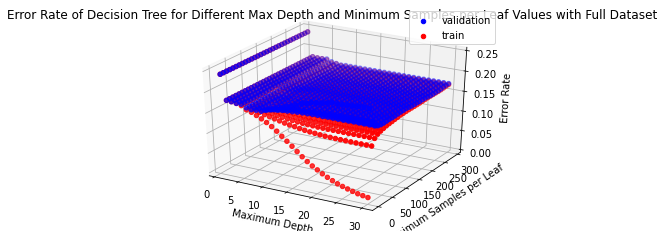

In [ ]:
# Temporary lits to compute quickly
max_depth_list = list(range(1,31)) #1-30
min_samples_per_leaf_list = list(range(1,301,10)) #1-100

err_val_matrix, err_train_matrix = my_validation.dt_cross_validation(x_train, y_train,max_depth_list=max_depth_list, min_samples_per_leaf_list=min_samples_per_leaf_list, L=L, validation_metric_fn=my_validation.error_rate)
err_val_means = np.mean(err_val_matrix, axis = -1)
err_train_means = np.mean(err_train_matrix, axis = -1)

err_val_min_params = np.where(err_val_means == np.amin(err_val_means))
display(err_val_min_params)
fig, ax = plt.subplots(subplot_kw={'projection': '3d'})
xdata = list()
for md in max_depth_list:
  for i in range(len(min_samples_per_leaf_list)):
    xdata.append(md)

ydata = len(max_depth_list) * min_samples_per_leaf_list

zdata_val, zdata_train = err_val_means.flatten(), err_train_means.flatten()

# The best parameter is the one providing the smallest error rate
best_max_depth_combine = max_depth_list[err_val_min_params[0][0]]
print("Best max depth parameter: {k}".format(k=best_max_depth_combine))
best_min_samples_combine = min_samples_per_leaf_list[err_val_min_params[1][0]]
print("Best min samples per leaf parameter: {k}".format(k=best_min_samples_combine))

# Visualization
ax.scatter3D(xdata, ydata, err_val_means, label='validation', color='blue')

ax.scatter3D(xdata,ydata, err_train_means, label='train', color='red')

ax.set_title('Error Rate of Decision Tree for Different Max Depth and Minimum Samples per Leaf Values with Full Dataset')
ax.legend()
ax.set_xlabel('Maximum Depth')
ax.set_ylabel('Minimum Samples per Leaf')
ax.set_zlabel('Error Rate')
plt.show()

#### Use Best Parameter Combination on Test Set

In [ ]:
model = DecisionTreeClassifier(max_depth=best_max_depth_combine, min_samples_leaf=best_min_samples_combine)
start_time = time.time()
model.fit(x_train, y_train)
tr_end = time.time()
tr_time = tr_end - start_time

y_pred = model.predict(x_test)
pr_end = time.time()
pred_time = pr_end - tr_end

err_rate = my_validation.error_rate(y_test, y_pred)

print("Error Rate on Test Set: {err_rate}".format(err_rate=err_rate))
print("Training time: {tr_time}".format(tr_time=tr_time))
print("Prediction time: {pred_time}".format(pred_time=pred_time))

Error Rate on Test Set: 0.5656286468890117
Training time: 0.18924474716186523
Prediction time: 0.014564037322998047
